Necessary imports

In [13]:
%pip install pandas
%pip install plotly
%pip install matplotlib
%pip install scipy

from scipy import stats
import pandas as pd
import plotly.express as px

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Carregamento de dados

A partir do site que pegamos o arquivo (http://dados.recife.pe.gov.br/pt_BR/dataset/servico-de-atendimento-movel-de-urgencia-samu-2022/resource/7c005351-2d14-46cf-b2f0-6622a5553b30), os tipos dos dados são:

data: timestamp

hora_minuto: text municipio: text

bairro: text

endereco: text

origem_chamado: text

tipo: text

subtipo: text

sexo: text

idade: numeric

motivo_finalizacao: text

motivo_desfecho: text

In [3]:
dtypes = {
    "hora_minuto":  str,
    "municipio": "category",
    "bairro": "category",
    "endereco": "category",
    "origem_chamado": "category",
    "tipo": "category",
    "subtipo": "category",
    "sexo": "category",
    "idade": float,
    "motivo_finalizacao": "category",
    "motivo_desfecho": "category",
}

columns_to_datetime = ["data"]

raw_df = pd.read_csv("./datasets/ocorrencias2022.csv", sep=';', dtype=dtypes, parse_dates=columns_to_datetime)
raw_df.head()

,data,hora_minuto,municipio,bairro,endereco,origem_chamado,tipo,subtipo,sexo,idade,motivo_finalizacao,motivo_desfecho
0,2022-01-01,00:02:19,RECIFE,JARDIM SAO PAULO,R LEANDRO BARRETO,RESIDENCIAL,RESPIRATORIA,CASO SUSPEITO COVID-19,FEMININO,81.0,NaN,PACIENTE RECUSA SER REMOVIDO
1,2022-01-01,00:03:00,RECIFE,MADALENA,R ALTINHO,RESIDENCIAL,CAUSAS EXTERNAS,QUEDA DA PROPRIA ALTURA,FEMININO,81.0,NaN,DESISTÊNCIA DA SOLICITAÇÃO
2,2022-01-01,00:09:38,MACAPARANA,CENTRO,R POSSIDONIO JULIAO DA SILVA,VIA PÚBLICA,CAUSAS EXTERNAS,OUTROS,MASCULINO,0.0,REGULAÇÃO POR TELEFONE,SEM DESFECHO
3,2022-01-01,00:10:02,VITORIA DE SANTO ANTAO,CENTRO,RUA JOSE COSTA N 93 BAIRRO DA,RESIDENCIAL,GERAIS/OUTROS,OUTROS,FEMININO,NaN,DESISTÊNCIA DA SOLICITAÇÃO,SEM DESFECHO
4,2022-01-01,00:12:16,PALMARES,PALMARES CENTRO,RUA DOUTOR COSTA MAIA,RESIDENCIAL,GERAIS/OUTROS,OUTROS,MASCULINO,84.0,NaN,OCORRÊNCIA CONCLUÍDA COM ÊXITO


# Considerações iniciais sobre o dataset

O dataset descreve ligações para o Serviço de Atendimento Móvel de Urgência (SAMU), realizados no ano de 2022.
Possui informações que identificam:

O local e hora onde uma ocorrência foi registrada;

Sexo e idade que identificam o indivíduo responsável pelo chamado;

Municipio, Bairro e Endereço do chamado;

Tipo e Subtipo do chamado;

E por fim, motivos da finalização e desfecho do chamado.

In [4]:
raw_df.describe()

,idade
count,93764.000000
mean,47.013886
std,25.460475
min,0.000000
25%,28.000000
50%,47.000000
75%,67.000000
max,747.000000


In [5]:
raw_df.dtypes

data                  datetime64[ns]
hora_minuto                   object
municipio                   category
bairro                      category
endereco                    category
origem_chamado              category
tipo                        category
subtipo                     category
sexo                        category
idade                        float64
motivo_finalizacao          category
motivo_desfecho             category
dtype: object

In [6]:
raw_df.isna().sum()

data                      0
hora_minuto               0
municipio                 3
bairro                    4
endereco               1914
origem_chamado            0
tipo                      0
subtipo                  17
sexo                   1399
idade                   926
motivo_finalizacao    60456
motivo_desfecho           0
dtype: int64

Já que mais da metade do dataset está com a coluna "motivo_finalizacao" vazia, será impraticável utilizar essa coluna na nossa análise, portanto removeremos ela.

para o restante das colunas, nós removeremos as instâncias que contém alguma coluna vazia, com exceção da coluna de endereço, já que ela não vai ser tão útil para a análise que queremos.

A remoção dessas instâncias não vão fazer muita diferença já que a quantidade das linhas removidas são ínfimas, (menos de 5%), em comparação à quantidade total de dados do dataset.

Tratando dados vazios

Grande parte dos motivos de finalização estão vazios.
Sexo e idade tem um número relevante de valores faltantes, então utilizamos a função fillna(), com o método forward fill.

In [7]:
raw_df = raw_df.drop("motivo_finalizacao", axis=1)
raw_df = raw_df.dropna(subset=["municipio", "bairro", "subtipo", "sexo", "idade"])
raw_df.isna().sum()

data                  0
hora_minuto           0
municipio             0
bairro                0
endereco           1838
origem_chamado        0
tipo                  0
subtipo               0
sexo                  0
idade                 0
motivo_desfecho       0
dtype: int64

In [8]:
raw_df["idade"].describe()

count    92459.000000
mean        47.110211
std         25.315927
min          0.000000
25%         28.000000
50%         47.000000
75%         67.000000
max        747.000000
Name: idade, dtype: float64

ter a idade máxima de 747 é impossível, uma passada no google diz que há pessoas com certificados de nascimento entre 115 anos até 121 anos, portanto nós escolhemos definir uma idade máxima de 120 anos para deixar mais fácil de discretizar a idade em uma série de 6 categorias.

In [9]:
def older_than_120(age: int):
  if age >= 120:
    return 120
  return age

raw_df["idade"] = raw_df["idade"].apply(lambda x : older_than_120(x))
raw_df["idade"].describe()

count    92459.000000
mean        47.088656
std         25.079854
min          0.000000
25%         28.000000
50%         47.000000
75%         67.000000
max        120.000000
Name: idade, dtype: float64

In [10]:
raw_df["faixa_etaria"] = pd.cut(raw_df["idade"], 6)
raw_df["faixa_etaria"]

0        (80.0, 100.0]
1        (80.0, 100.0]
2        (-0.12, 20.0]
4        (80.0, 100.0]
5        (-0.12, 20.0]
             ...      
94685     (40.0, 60.0]
94686     (60.0, 80.0]
94687    (-0.12, 20.0]
94688     (40.0, 60.0]
94689    (80.0, 100.0]
Name: faixa_etaria, Length: 92459, dtype: category
Categories (6, interval[float64, right]): [(-0.12, 20.0] < (20.0, 40.0] < (40.0, 60.0] < (60.0, 80.0] < (80.0, 100.0] < (100.0, 120.0]]

<AxesSubplot:>

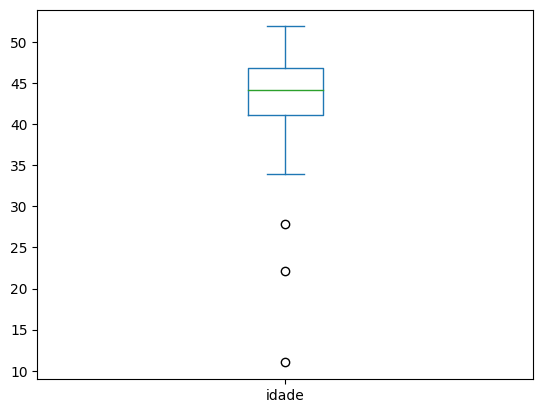

In [14]:
idade_ascending = raw_df.groupby("municipio")["idade"].mean().sort_values(ascending=True)
idade_ascending.plot.box()

<AxesSubplot:ylabel='Frequency'>

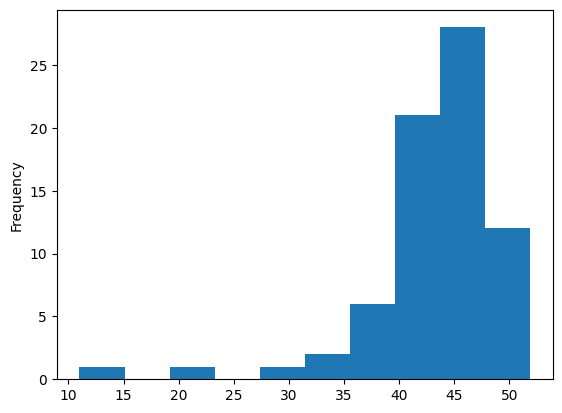

In [15]:
idade_ascending.plot.hist()

In [16]:
stats.shapiro(idade_ascending)[1]

9.995663852180314e-09

# Testes de hipótese
1. A distribuição de Faixa Etária para os tipos de ocorrência "CARDIOLOGICA" e "RESPIRATORIA" são semelhantes. 
2. As frequências de tipos de ocorrência são semelhantes para cada um dos 5 Municipios com maior número de ocorrências em Recife.
3. Ocorrências que foram determinadas como "TROTE" são mais prováveis de serem atribuídas a homens.
4. Ocorrências do tipo "CAUSAS EXTERNAS" resultam em mais óbitos que os demais tipos.

Como o dataset não possui uma distribuição normal, utilizaremos, geralmente, os tipos de dados "Rank" e "Score".

1. A distribuição de idade para os tipos de ocorrência "CARDIOLOGICA" e "RESPIRATORIA" são semelhantes. 

A ideia dessa hipótese é atestar que,

3. Ocorrências que foram determinadas como "TROTE" são mais prováveis de serem atribuídas a homens.

Com esse teste de hipótese, gostaríamos de testar a teoria de que homens cometem mais trotes. Como os indivíduos descritos pelo dataset não são pareados, utilizaremos a técnica de teste "Mann-Whitney".

Hipótese Nula a ser testada: Não há diferença significativa entre os números de trotes, separados por municípios, praticados por aqueles que identificaram-se como do sexo masculino e daqueles que identificaram-se como do sexo feminino.

In [30]:
trotes_df = raw_df[raw_df['motivo_desfecho'] == 'TROTE']
trotes_table = trotes_df.groupby(['municipio', 'sexo'])['data'].agg(['count']).reset_index()
trotes_table

,municipio,sexo,count
0,ABREU E LIMA,FEMININO,1
1,ABREU E LIMA,MASCULINO,0
2,AGUA PRETA,FEMININO,0
3,AGUA PRETA,MASCULINO,1
4,ALIANCA,FEMININO,1
...,...,...,...
139,VICENCIA,MASCULINO,0
140,VITORIA DE SANTO ANTAO,FEMININO,1
141,VITORIA DE SANTO ANTAO,MASCULINO,5
142,XEXEU,FEMININO,0


In [35]:
trotes_femininos_por_municipio = trotes_table[trotes_table['sexo'] == 'FEMININO']
trotes_masculinos_por_municipio = trotes_table[trotes_table['sexo'] == 'MASCULINO']

# Taking the list of frequencies
trotes_femininos_por_municipio = trotes_femininos_por_municipio['count'].to_list()
trotes_masculinos_por_municipio = trotes_masculinos_por_municipio['count'].to_list()

len(trotes_femininos_por_municipio) == len(trotes_masculinos_por_municipio)

True

In [36]:

from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(trotes_femininos_por_municipio, trotes_masculinos_por_municipio)
print('Statistics=%.2f, p=%.2f' % (stat, p_value))

# Level of significance
alpha = 0.05
# conclusion
if p_value < alpha:
    print('Reject Null Hypothesis (Significant difference between two samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Statistics=2546.00, p=0.82
Do not Reject Null Hypothesis (No significant difference between two samples)


Como não podemos rejeitar a hipótese nula, podemos afirmar que desprovamos nossa hipótese:

A frequência de trotes praticados por homens e mulheres, agrupados por municípios, é, na verdade, bastante semelhante.